# Image Captioning

This is to build a deep neural net model to generate descriptive caption for an image that we provide.

In [1]:
!nvidia-smi

Fri Nov 20 16:12:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 603.7MB 27kB/s 
     |████████████████████████████████| 6.5MB 5.9MB/s 


In [3]:
GDRIVE_PATH = '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S12_ImageCaptioning'

### Import packages

In [4]:
import os
import shutil
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt


In [3]:
cd $GDRIVE_PATH

/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S12_ImageCaptioning


In [4]:
from models import Encoder, DecoderWithAttention
from datasets import *
from utils import *

In [5]:
cd /content

/content


## Prepare dataset

Flickr30K dataset is available on Kaggle dataset. To download dataset from Kaggle, identity key is required.

In [8]:
# Since Flickr30K dat
!pip install kaggle
shutil.copy(os.path.join(GDRIVE_PATH,"kaggle.json"), os.getcwd())

'/content/kaggle.json'

In [9]:
!mkdir ~/.kaggle && cp ./kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d hsankesara/flickr-image-dataset && unzip -q flickr-image-dataset.zip

100% 8.16G/8.16G [16:02<00:00, 5.37MB/s]
100% 8.16G/8.16G [16:02<00:00, 9.11MB/s]


In [11]:
ls /content/flickr30k_images/flickr30k_images | wc -l

31785


### Prepare captions for Flickr 30K dataset.

In [12]:
!wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip

--2020-11-20 16:34:29--  http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip [following]
--2020-11-20 16:34:29--  https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36745453 (35M) [application/zip]
Saving to: ‘caption_datasets.zip’

caption_datasets.zi 100%[===================>]  35.04M  11.7MB/s    in 3.0s    

2020-11-20 16:34:33 (11.7 MB/s) - ‘caption_datasets.zip’ saved [36745453/36745453]



In [13]:
!unzip caption_datasets.zip

Archive:  caption_datasets.zip
  inflating: dataset_coco.json       
  inflating: dataset_flickr30k.json  
  inflating: dataset_flickr8k.json   


### Parameters

In [14]:
dataset = 'flickr30k'
karpathy_json_path = 'dataset_flickr30k.json'
image_folder = '/content/flickr30k_images/flickr30k_images'
captions_per_image = 5
min_word_freq = 5
output_folder = '/content/output_folder'
max_len=50

# Data parameters
data_folder = '/content/output_folder'  # folder with data files saved by create_input_files.py
data_name = 'flickr30k_5_cap_per_img_5_min_word_freq'  # base name shared by data files

In [15]:
# Model parameters
emb_dim = 512
attention_dim = 512
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [16]:
# Training parameters
start_epoch = 0
epochs = 5  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 64
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 1000  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

In [17]:
mkdir output_folder

### Prepare hdf5 and json files

In [18]:
create_input_files(dataset, karpathy_json_path, image_folder, captions_per_image, min_word_freq, output_folder, max_len)

  0%|          | 6/29000 [00:00<08:20, 57.93it/s]


Reading TRAIN images and captions, storing to file...



  1%|          | 10/1014 [00:00<00:10, 99.79it/s]


Reading VAL images and captions, storing to file...



  1%|          | 10/1000 [00:00<00:10, 94.27it/s]


Reading TEST images and captions, storing to file...



100%|██████████| 1000/1000 [00:10<00:00, 97.76it/s]


### Load word_map, word_map and dataloader

In [24]:
global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

# Read word map
word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

map_word = {v:k for k, v in word_map.items()}

In [26]:
# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

### View image

In [27]:
(imgs, caps, caplens) = next(iter(train_loader))

In [28]:
label = []
for cap in caps[:3]:
    capt = [map_word[i.item()] for i in cap if i !=0]
    capt = capt[1:-1]
    capt = " ".join(capt)
    label.append(capt)

In [29]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

In [30]:
def display_image_class(image_array, label_array, fig_size = (8, 8)):
    fig, axs = plt.subplots(len(image_array), 1, figsize = fig_size, squeeze=False)
    fig.tight_layout()

    for i in range(len(image_array)):
        axs[i][0].axis("off")
        axs[i][0].set_title(f'Label: {label_array[i]}')
        axs[i][0].imshow(image_array[i].squeeze(0).permute(1,2,0))

In [31]:
denorm_image = denormalize(imgs[:3], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

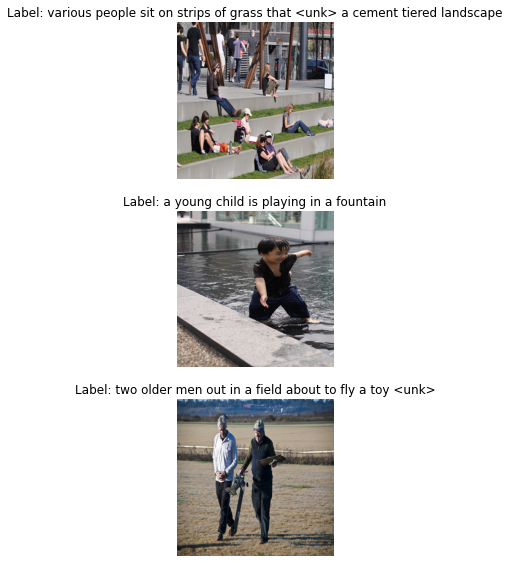

In [32]:
display_image_class(denorm_image, label)

### Training

In [33]:
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                    embed_dim=emb_dim,
                                    decoder_dim=decoder_dim,
                                    vocab_size=len(word_map),
                                    dropout=dropout)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                            lr=decoder_lr)
    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                lr=encoder_lr)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [34]:
# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [35]:
# Training
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores.data, targets.data)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores.data, targets.data, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

In [36]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores.data, targets.data)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores.data, targets.data, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [37]:
# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train(train_loader=train_loader,
            encoder=encoder,
            decoder=decoder,
            criterion=criterion,
            encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer,
            epoch=epoch)

    # One epoch's validation
    recent_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion)

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)

Epoch: [0][0/2266]	Batch Time 1.679 (1.679)	Data Load Time 0.423 (0.423)	Loss 9.7841 (9.7841)	Top-5 Accuracy 0.119 (0.119)
Epoch: [0][1000/2266]	Batch Time 0.417 (0.435)	Data Load Time 0.000 (0.001)	Loss 4.7270 (5.2315)	Top-5 Accuracy 56.098 (49.692)
Epoch: [0][2000/2266]	Batch Time 0.439 (0.433)	Data Load Time 0.000 (0.000)	Loss 4.1635 (4.8748)	Top-5 Accuracy 62.569 (54.008)
Validation: [0/80]	Batch Time 0.857 (0.857)	Loss 3.9900 (3.9900)	Top-5 Accuracy 65.820 (65.820)	

 * LOSS - 4.199, TOP-5 ACCURACY - 62.596, BLEU-4 - 0.12391295597158705

Epoch: [1][0/2266]	Batch Time 0.766 (0.766)	Data Load Time 0.285 (0.285)	Loss 4.1422 (4.1422)	Top-5 Accuracy 62.422 (62.422)
Epoch: [1][1000/2266]	Batch Time 0.411 (0.432)	Data Load Time 0.000 (0.000)	Loss 4.2904 (4.2234)	Top-5 Accuracy 61.519 (61.818)
Epoch: [1][2000/2266]	Batch Time 0.439 (0.431)	Data Load Time 0.000 (0.000)	Loss 3.9752 (4.1737)	Top-5 Accuracy 62.941 (62.498)
Validation: [0/80]	Batch Time 0.612 (0.612)	Loss 3.9344 (3.9344)	Top-5

### Copy the best checkpoint and wordmap

In [ ]:
print('Size (MB):', os.path.getsize("BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar")/1e6)

Size (MB): 385.832159


In [ ]:
print('Size (MB):', os.path.getsize("BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar")/(1024*1024))

Size (MB): 367.95822048187256


In [ ]:
shutil.copy('BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar', os.path.join(GDRIVE_PATH,'saved_models'))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S12_ImageCaptioning/saved_models/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'

In [ ]:
shutil.copy(os.path.join('/content/output_folder/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'), os.path.join(GDRIVE_PATH,'saved_models'))

'/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S12_ImageCaptioning/saved_models/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'

### Model inferencing

In [6]:
import shutil
import os

In [5]:
# Required only for now
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
checkpoint = 'BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar'
word_map_file = 'WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
image_name = 'man.jpg'

In [7]:
shutil.copy(os.path.join(GDRIVE_PATH,"saved_models/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar"), os.getcwd())
shutil.copy(os.path.join(GDRIVE_PATH,"saved_models/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json"), os.getcwd())

'/content/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'

In [8]:
cd $GDRIVE_PATH

/gdrive/My Drive/Colab Notebooks/SchoolOfAI/EVAP2/S12_ImageCaptioning


In [9]:
# If running fresh, execute below
from datasets import *
from utils import *
from models import Encoder, DecoderWithAttention
from image_caption import *

In [10]:
cd /content

/content


In [11]:
image = Image.open(image_name)

Encoder-Decoder model loaded
Word map dict loaded


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Images's caption- a man in jeans and a blue shirt is walking down a sidewalk
a man in jeans and a blue shirt is walking down a sidewalk


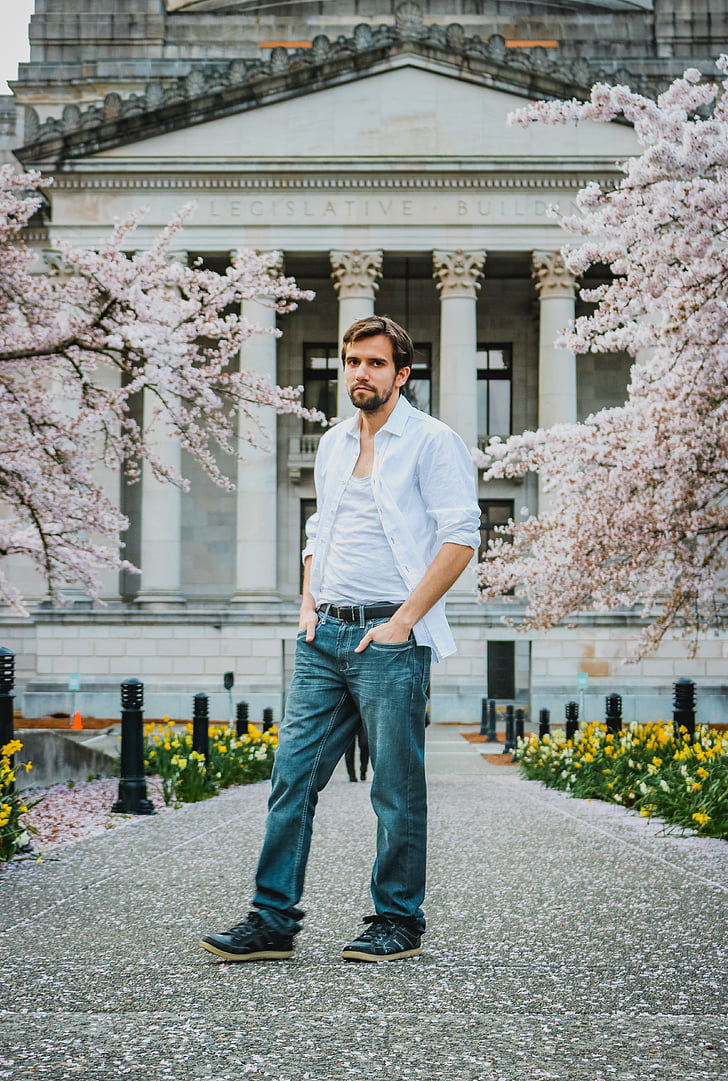

In [12]:
print(caption_image(checkpoint, word_map_file, image))
image


### Caption image

In [21]:
import skimage.transform
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


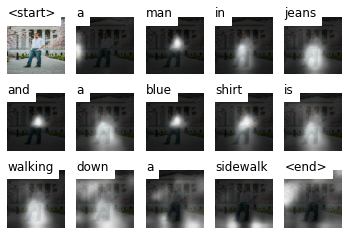

In [22]:
encoder, decoder = load_model(checkpoint)
word_map, rev_word_map = load_word_map(word_map_file)
seq, alphas = caption_image_beam_search(encoder, decoder, image, word_map, beam_size=3)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att(image_name, seq, alphas, rev_word_map)